In [1]:
import re
from tqdm.notebook import tqdm

from IPython.display import display

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers

from covid_flu import config, utils, time_series, plotting

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
df_flu = utils.load_flu_data()
display(df_flu.head())
display(df_flu.tail())

,time,wili,state
0,2010-40,2.13477,Alabama
1,2010-41,2.05999,Alabama
2,2010-42,1.94224,Alabama
3,2010-43,2.27650,Alabama
4,2010-44,2.83371,Alabama


,time,wili,state
456,2019-27,0.280899,Wyoming
457,2019-28,0.166021,Wyoming
458,2019-29,0.000100,Wyoming
459,2019-30,0.000100,Wyoming
460,2019-31,0.000100,Wyoming


## Simple RNN model: predicting `d` days from a fixed input length

In [9]:
ds_train, ds_test = time_series.prepare_data(df_flu['wili'].values, 
                                             df_flu['state'].values,
                                             history_size=25, 
                                             target_size=1, 
                                             test_size=0.2)

### Constructing the RNN

In [10]:
def make_simple_lstm(history_length=25, target_length=1, hidden_size=8, pre_output_dense_size=None):
    simple_lstm = tf.keras.models.Sequential()
    simple_lstm.add(layers.LSTM(hidden_size, input_shape=(history_length,1)))
    if pre_output_dense_size:
        simple_lstm.add(layers.Dense(pre_output_dense_size))
    simple_lstm.add(layers.Dense(target_length))
    
    simple_lstm.compile(optimizer='adam', loss='mse')
    return simple_lstm

In [11]:
simple_lstm = make_simple_lstm()

In [12]:
simple_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 8)                 320       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________


In [13]:
history = simple_lstm.fit(ds_train, epochs=EPOCHS, validation_data=ds_test)

Train for 72 steps, validate for 18 steps
Epoch 1/20
72/72 [==============================] - 4s 51ms/step - loss: 5.9038 - val_loss: 3.2056
Epoch 2/20
72/72 [==============================] - 1s 17ms/step - loss: 3.6696 - val_loss: 2.1142
Epoch 3/20
72/72 [==============================] - 1s 17ms/step - loss: 2.7536 - val_loss: 1.6686
Epoch 4/20
72/72 [==============================] - 2s 22ms/step - loss: 2.2634 - val_loss: 1.3803
Epoch 5/20
72/72 [==============================] - 1s 17ms/step - loss: 1.9118 - val_loss: 1.1535
Epoch 6/20
72/72 [==============================] - 1s 19ms/step - loss: 1.6292 - val_loss: 0.9659
Epoch 7/20
72/72 [==============================] - 1s 18ms/step - loss: 1.3518 - val_loss: 0.8222
Epoch 8/20
72/72 [==============================] - 1s 17ms/step - loss: 1.1709 - val_loss: 0.7220
Epoch 9/20
72/72 [==============================] - 2s 21ms/step - loss: 1.0311 - val_loss: 0.6561
Epoch 10/20
72/72 [==============================] - 1s 17ms/step -

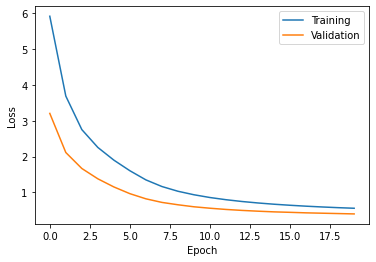

In [14]:
plotting.plot_history(history)

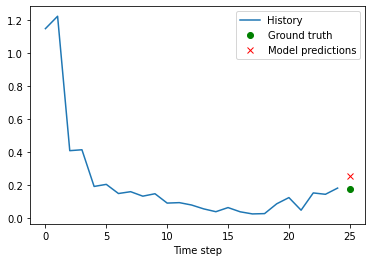

In [16]:
plotting.plot_model_pred(simple_lstm, ds_test)

## Evaluating with walk-forward validation

In [39]:
TEST_SIZE = 0.2
X_test = []
for state in df_flu['state'].unique():
    ts = df_flu.loc[df_flu['state'] == state, 'wili'].values
    len_test = int(np.ceil(len(ts) * TEST_SIZE))
    X_test.append(ts[-len_test:])

In [40]:
len(X_test)

53

In [41]:
X_test[0].shape, X_test[10].shape

((93,), (93,))

In [45]:
time_series.walk_forward_val_multiple(simple_lstm, X_test,
                                      history_size=25,
                                      target_size=1)

array([[0.37102792]])

## Trying to predict a longer time horizon

In [21]:
history_size = 50
target_size = 5
ds_train, ds_test = time_series.prepare_data(df_flu['wili'].values,
                                             df_flu['state'].values,
                                             history_size=history_size,
                                             target_size=target_size)
lstm2 = make_simple_lstm(history_length=history_size, target_length=target_size)
lstm2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 8)                 320       
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 45        
Total params: 365
Trainable params: 365
Non-trainable params: 0
_________________________________________________________________


In [22]:
history2 = lstm2.fit(ds_train, epochs=EPOCHS, validation_data=ds_test)

Train for 67 steps, validate for 17 steps
Epoch 1/25
67/67 [==============================] - 5s 75ms/step - loss: 5.3580 - val_loss: 3.2873
Epoch 2/25
67/67 [==============================] - 2s 35ms/step - loss: 4.0885 - val_loss: 2.4401
Epoch 3/25
67/67 [==============================] - 3s 38ms/step - loss: 3.1022 - val_loss: 1.8469
Epoch 4/25
67/67 [==============================] - 2s 36ms/step - loss: 2.4107 - val_loss: 1.5145
Epoch 5/25
67/67 [==============================] - 2s 36ms/step - loss: 2.0218 - val_loss: 1.3287
Epoch 6/25
67/67 [==============================] - 3s 40ms/step - loss: 1.8064 - val_loss: 1.2293
Epoch 7/25
67/67 [==============================] - 3s 38ms/step - loss: 1.6552 - val_loss: 1.1484
Epoch 8/25
67/67 [==============================] - 3s 37ms/step - loss: 1.5478 - val_loss: 1.1017
Epoch 9/25
67/67 [==============================] - 2s 36ms/step - loss: 1.4693 - val_loss: 1.0573
Epoch 10/25
67/67 [==============================] - 2s 34ms/step -

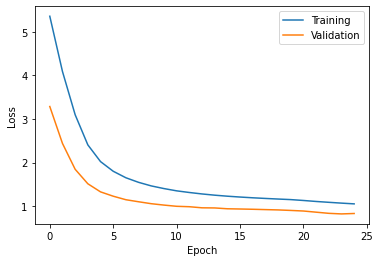

In [23]:
plotting.plot_history(history2)

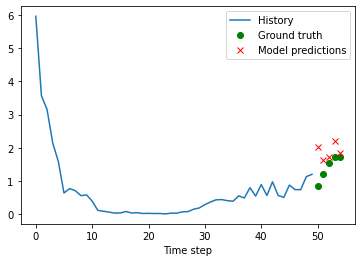

In [24]:
plotting.plot_model_pred(lstm2, ds_test)

## Adding a pre-output dense layer and more hidden nodes

In [25]:
history_size = 50
target_size = 5
hidden_size = 16
pre_output_dense_size = 32
lstm3 = make_simple_lstm(history_length=history_size,
                         target_length=target_size,
                         hidden_size=hidden_size,
                         pre_output_dense_size=pre_output_dense_size)
lstm3.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 16)                1152      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 165       
Total params: 1,861
Trainable params: 1,861
Non-trainable params: 0
_________________________________________________________________


In [26]:
history3 = lstm3.fit(ds_train, epochs=EPOCHS, validation_data=ds_test)

Train for 67 steps, validate for 17 steps
Epoch 1/25
67/67 [==============================] - 6s 83ms/step - loss: 4.6275 - val_loss: 1.9582
Epoch 2/25
67/67 [==============================] - 3s 40ms/step - loss: 2.0521 - val_loss: 1.2884
Epoch 3/25
67/67 [==============================] - 5s 68ms/step - loss: 1.3556 - val_loss: 1.0261
Epoch 4/25
67/67 [==============================] - 4s 59ms/step - loss: 1.1609 - val_loss: 0.9808
Epoch 5/25
67/67 [==============================] - 4s 59ms/step - loss: 1.1099 - val_loss: 0.9650
Epoch 6/25
67/67 [==============================] - 3s 51ms/step - loss: 1.0887 - val_loss: 0.9513
Epoch 7/25
67/67 [==============================] - 4s 60ms/step - loss: 1.0770 - val_loss: 0.9434
Epoch 8/25
67/67 [==============================] - 4s 52ms/step - loss: 1.0664 - val_loss: 0.8921
Epoch 9/25
67/67 [==============================] - 4s 58ms/step - loss: 1.0335 - val_loss: 0.8721
Epoch 10/25
67/67 [==============================] - 3s 48ms/step -

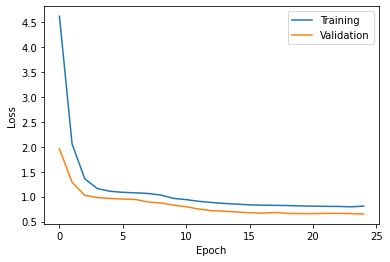

In [27]:
plotting.plot_history(history3)

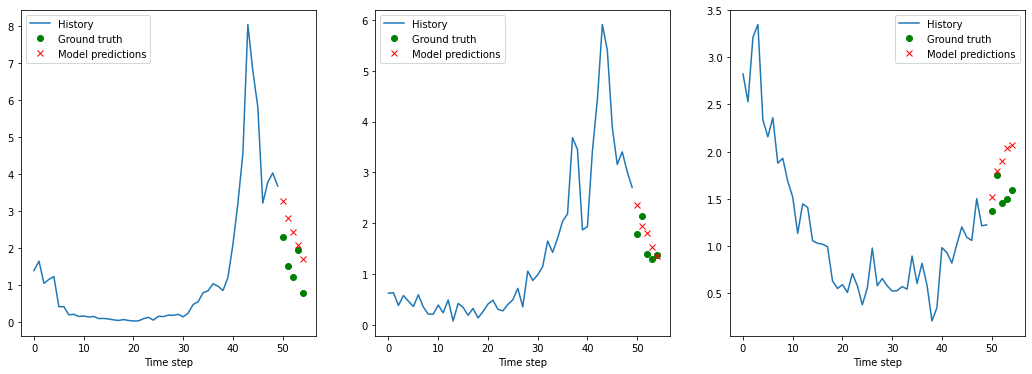

In [30]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
for ax in axs:
    plotting.plot_model_pred(lstm3, ds_test, ax=ax)

## Okay cool that seems to work really welll. What if we play with the history and target window size some more?

In [33]:
history_size = 25
target_size = 10
hidden_size = 16
pre_output_size = 32

ds_train, ds_test = time_series.prepare_data(df_flu['wili'].values,
                                             df_flu['state'].values,
                                             history_size=history_size,
                                             target_size=target_size)
lstm4 = make_simple_lstm(history_length=history_size,
                         target_length=target_size,
                         hidden_size=hidden_size,
                         pre_output_dense_size=pre_output_dense_size)
lstm4.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 16)                1152      
_________________________________________________________________
dense_8 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_9 (Dense)              (None, 10)                330       
Total params: 2,026
Trainable params: 2,026
Non-trainable params: 0
_________________________________________________________________


In [34]:
history4 = lstm4.fit(ds_train, validation_data=ds_test, epochs=EPOCHS)

Train for 70 steps, validate for 18 steps
Epoch 1/25
70/70 [==============================] - 4s 54ms/step - loss: 4.3732 - val_loss: 2.1592
Epoch 2/25
70/70 [==============================] - 2s 23ms/step - loss: 2.3884 - val_loss: 1.6982
Epoch 3/25
70/70 [==============================] - 2s 22ms/step - loss: 1.9120 - val_loss: 1.5379
Epoch 4/25
70/70 [==============================] - 1s 20ms/step - loss: 1.7929 - val_loss: 1.4677
Epoch 5/25
70/70 [==============================] - 2s 33ms/step - loss: 1.7357 - val_loss: 1.4037
Epoch 6/25
70/70 [==============================] - 2s 26ms/step - loss: 1.7055 - val_loss: 1.3668
Epoch 7/25
70/70 [==============================] - 2s 22ms/step - loss: 1.6871 - val_loss: 1.3670
Epoch 8/25
70/70 [==============================] - 1s 20ms/step - loss: 1.6592 - val_loss: 1.3340
Epoch 9/25
70/70 [==============================] - 1s 20ms/step - loss: 1.6399 - val_loss: 1.3803
Epoch 10/25
70/70 [==============================] - 2s 26ms/step -

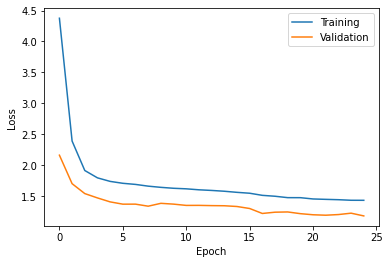

In [35]:
plotting.plot_history(history4)

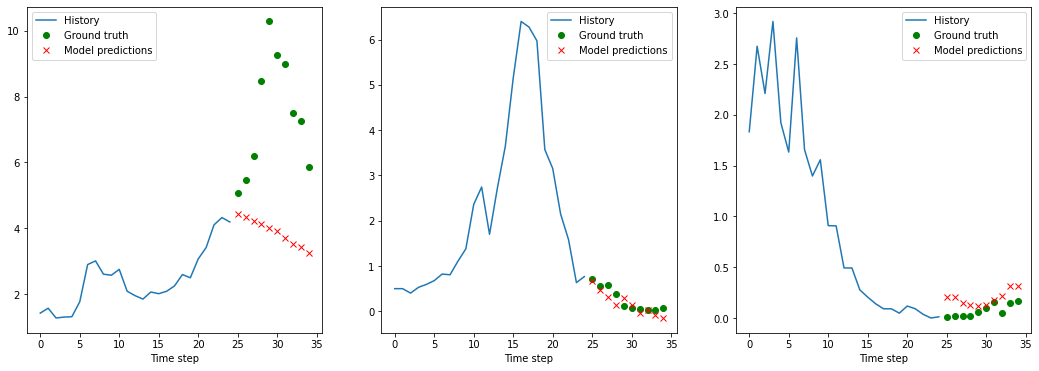

In [38]:
plotting.plot_model_pred(lstm4, ds_test, n=3)

Wow this is actually quite good already!

## Variable history and prediction windows

The strength of RNNs is that they permit a variable-length history and target. We can do this by having the RNN at training time learn to predict the next time point given the entire history. At inference time, we then predict the next data point one at a time, whereupon we take the last predicted data point and add it to the total history.

We will use walk-forward validation